{'inference_id': 'd4ba9c45-bd03-4eb2-904c-1a1b79004b96', 'time': 0.03635585499978333, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 227.5, 'y': 350.0, 'width': 99.0, 'height': 264.0, 'confidence': 0.9131731986999512, 'class': 'bottle', 'class_id': 0, 'detection_id': '9830d823-9ff3-4541-a902-8800ce350730'}]}


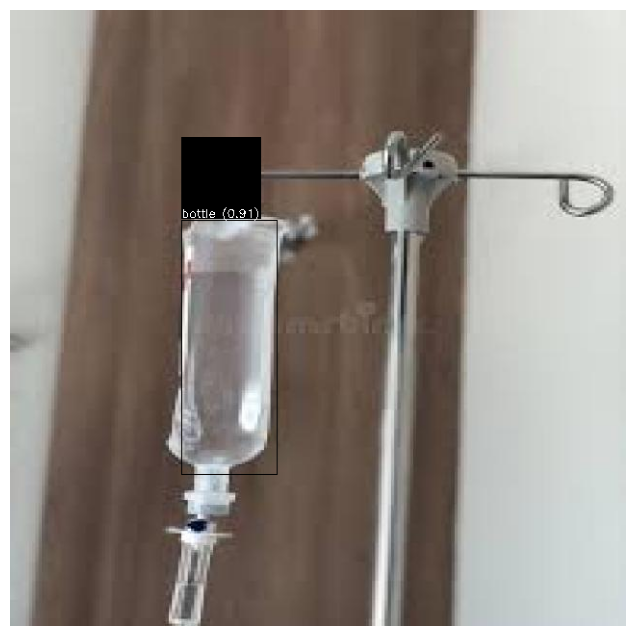

In [1]:
# import the necessary libraries
import base64
from inference_sdk import InferenceHTTPClient
import cv2
import matplotlib.pyplot as plt


# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="5Oijo8OWOGEpIsnA2iQz"
)

# Load and encode your image in base64
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"
with open(image_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

# infer on the encoded image
result = CLIENT.infer(encoded_image, model_id="cv-90ctx/3")

# Print the result
print(result)
# Path to your image
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"

# Load the image
image = cv2.imread(image_path)

# Extract bounding box info from the inference result
predictions = result['predictions']

# Loop through predictions and draw bounding boxes
for prediction in predictions:
    x = int(prediction['x'] - prediction['width'] / 2)
    y = int(prediction['y'] - prediction['height'] / 2)
    width = int(prediction['width'])
    height = int(prediction['height'])
    confidence = prediction['confidence']
    
    # Draw rectangle for bounding box
    cv2.rectangle(image, (x, y), (x + width, y + height), (0, 0, 0), 1)
    
    # Add label with class name and confidence score
    label = f"{prediction['class']} ({confidence:.2f})"
    
    # Use a smaller, clearer font size and thickness
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.4 # Reduced font size for a neat appearance
    font_thickness = 1  # Keep thickness minimal
    
    # Calculate the text size to create a background
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    
    # Set the position for the label above the bounding box
    text_x = x
    text_y = y - 3 if y - 3 > 10 else y + 10 # Slight padding to avoid the edge
    
    # Draw background for the label (transparent or black)
    cv2.rectangle(image, (text_x, text_y - text_size[0] - 1), 
                  (text_x + text_size[0], text_y + 1), (0, 0, 0), -1)  # Background
    
    # Add the text label with white color
    cv2.putText(image, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)

# Convert image from BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes and new text
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

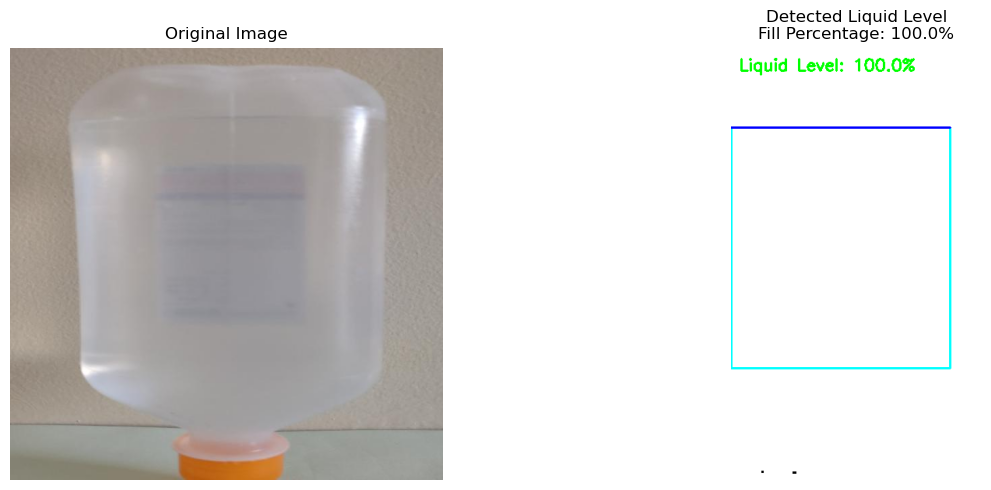

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations to clean up the image
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return cleaned

def detect_liquid_level(image_path, bbox_coordinates):
    # Read the image
    original_image = cv2.imread(image_path)
    
    # Extract bbox coordinates
    x, y, w, h = bbox_coordinates
    
    # Crop the image to the bottle region with some padding
    padding = 20
    x_start = max(0, x - padding)
    y_start = max(0, y - padding)
    x_end = min(original_image.shape[1], x + w + padding)
    y_end = min(original_image.shape[0], y + h + padding)
    
    bottle_roi = original_image[y_start:y_end, x_start:x_end]
    
    # Preprocess the image
    processed = preprocess_image(bottle_roi)
    
    # Find contours
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (should be the bottle)
    if contours:
        bottle_contour = max(contours, key=cv2.contourArea)
        
        # Create a mask for the bottle
        mask = np.zeros_like(processed)
        cv2.drawContours(mask, [bottle_contour], -1, (255), -1)
        
        # Define ROI for liquid level detection (middle section of bottle)
        roi_height = int(h * 0.6)  # 60% of bottle height
        roi_start_y = int(h * 0.2)  # Start from 20% height
        
        # Create visualization image
        vis_image = cv2.cvtColor(processed, cv2.COLOR_GRAY2BGR)
        
        # Analyze horizontal lines in the ROI
        liquid_level = None
        max_line_strength = 0
        
        for y in range(roi_start_y, roi_start_y + roi_height):
            # Get the row of pixels
            row = processed[y, :]
            # Count white pixels in the row (within the bottle mask)
            white_pixels = np.sum(row & mask[y, :]) // 255
            
            if white_pixels > max_line_strength:
                max_line_strength = white_pixels
                liquid_level = y
        
        if liquid_level is not None:
            # Draw ROI
            cv2.rectangle(vis_image, 
                         (0, roi_start_y),
                         (w, roi_start_y + roi_height),
                         (0, 255, 255), 2)
            
            # Draw detected liquid level
            cv2.line(vis_image,
                    (0, liquid_level),
                    (w, liquid_level),
                    (0, 0, 255), 2)
            
            # Calculate fill percentage
            fill_percentage = ((h - (liquid_level - roi_start_y)) / h) * 100
            fill_percentage = min(100, max(0, fill_percentage))
            
            # Add text annotations
            cv2.putText(vis_image,
                       f'Liquid Level: {fill_percentage:.1f}%',
                       (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.7,
                       (0, 255, 0),
                       2)
            
            return vis_image, fill_percentage
    
    return None, None

def visualize_results(original_image, processed_image, fill_percentage):
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Processed image with liquid level
    plt.subplot(122)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Detected Liquid Level\nFill Percentage: {fill_percentage:.1f}%')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Modified process_image function
def process_image(image_path, detection_result):
    original_image = cv2.imread(image_path)
    
    for prediction in detection_result['predictions']:
        # Extract bounding box coordinates
        x = int(prediction['x'] - prediction['width'] / 2)
        y = int(prediction['y'] - prediction['height'] / 2)
        width = int(prediction['width'])
        height = int(prediction['height'])
        
        # Detect liquid level
        processed_image, fill_percentage = detect_liquid_level(
            image_path, 
            (x, y, width, height)
        )
        
        if processed_image is not None and fill_percentage is not None:
            visualize_results(original_image, processed_image, fill_percentage)
        else:
            print("Failed to detect liquid level")

# Add function to analyze specific ROI for liquid level
def analyze_roi(image, roi_coords):
    x, y, w, h = roi_coords
    roi = image[y:y+h, x:x+w]
    
    # Convert ROI to grayscale if it's not already
    if len(roi.shape) == 3:
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Calculate the average intensity profile along rows
    intensity_profile = np.mean(roi, axis=1)
    
    # Find significant changes in intensity
    gradient = np.gradient(intensity_profile)
    liquid_level = np.argmax(np.abs(gradient)) + y
    
    return liquid_level


image_path = r"C:\Users\LAXMI\Downloads\cv images\IMG20200208143358_jpg.rf.f2481bc6a1c96aeec82e0c7b874b5d10.jpg"
process_image(image_path, result)


Detected fill percentage: 78.03%


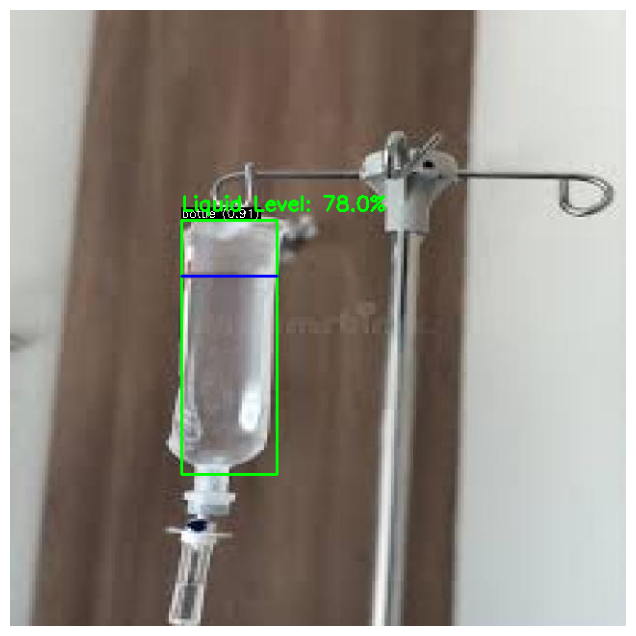

In [132]:
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient

# Initialize the client for Roboflow inference
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="5Oijo8OWOGEpIsnA2iQz"
)

# Function to preprocess the image and enhance contours
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)  # Inverse for better contour detection
    # Apply morphological operations to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return cleaned

# Function to detect and mark the liquid level
def detect_liquid_level(image, prediction):
    # Preprocess the image to get a binary mask
    processed = preprocess_image(image)

    # Get the bounding box around the bottle
    x, y, w, h = int(prediction['x'] - prediction['width'] / 2), int(prediction['y'] - prediction['height'] / 2), int(prediction['width']), int(prediction['height'])
    
    # Define the region of interest (ROI) for liquid level detection within the bottle
    roi_start_y = int(y + h * 0.2)  # Start from 20% height of the bottle
    roi_end_y = int(y + h * 0.8)    # End at 80% height of the bottle
    
    # Find the row with the most white pixels within the ROI
    liquid_level = None
    max_white_pixels = 0
    
    for i in range(roi_start_y, roi_end_y):
        row = processed[i, x:x + w]
        white_pixels = np.sum(row == 255)
        
        if white_pixels > max_white_pixels:
            max_white_pixels = white_pixels
            liquid_level = i
    
    if liquid_level is not None:
        # Draw the detected liquid level line on the original image
        cv2.line(image, (x, liquid_level), (x + w, liquid_level), (255, 0, 0), 2)  # Red line
        
        # Calculate fill percentage based on the liquid level height
        fill_percentage = ((y + h - liquid_level) / h) * 100
        fill_percentage = min(100, max(0, fill_percentage))
        
        # Display the fill percentage on the image
        cv2.putText(image, f'Liquid Level: {fill_percentage:.1f}%', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)  # Green text
        
        return fill_percentage

    return None

# Function to visualize the results
def visualize_results(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Main function to process the image
def process_image(image_path):
    # Load the image
    original_image = cv2.imread(image_path)
    
    # Load and encode your image in base64
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    # Infer on the encoded image
    result = CLIENT.infer(encoded_image, model_id="cv-90ctx/3")

    # Extract bounding box info from the inference result
    predictions = result['predictions']
    
    # Loop through predictions and draw bounding boxes
    for prediction in predictions:
        x = int(prediction['x'] - prediction['width'] / 2)
        y = int(prediction['y'] - prediction['height'] / 2)
        width = int(prediction['width'])
        height = int(prediction['height'])
        confidence = prediction['confidence']
        
        # Draw rectangle for bounding box
        cv2.rectangle(original_image, (x, y), (x + width, y + height), (0, 255, 0), 2)  # Green bounding box
        
        # Add label with class name and confidence score
        label = f"{prediction['class']} ({confidence:.2f})"
        
        # Calculate the text size to create a background
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.4
        font_thickness = 1
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        
        # Set the position for the label above the bounding box
        text_x = x
        text_y = y - 3 if y - 3 > 10 else y + 10
        
        # Draw background for the label
        cv2.rectangle(original_image, (text_x, text_y - text_size[1] - 1), 
                      (text_x + text_size[0], text_y + 1), (0, 0, 0), -1)  # Background
        
        # Add the text label with white color
        cv2.putText(original_image, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
        
        # Detect liquid level for each bottle
        fill_percentage = detect_liquid_level(original_image, prediction)
        if fill_percentage is not None:
            print(f"Detected fill percentage: {fill_percentage:.2f}%")

    # Visualize results
    visualize_results(original_image)

# Provide the path to your image
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"
process_image(image_path)


pygame 2.6.0 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Detected fill percentage: 78.03%


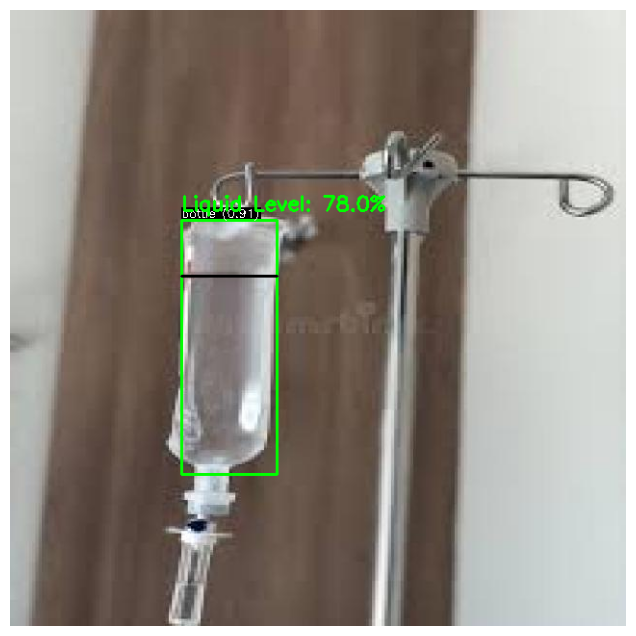

In [1]:
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
import pygame

# Initialize the client for Roboflow inference
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="5Oijo8OWOGEpIsnA2iQz"
)

# Function to preprocess the image and enhance contours
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)  # Inverse for better contour detection
    # Apply morphological operations to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    return cleaned

# Function to detect and mark the liquid level
def detect_liquid_level(image, prediction):
    # Preprocess the image to get a binary mask
    processed = preprocess_image(image)

    # Function to play alert sound
    def play_sound():
        pygame.mixer.init()  # Initialize the mixer
        pygame.mixer.music.load(r"C:\Users\LAXMI\Downloads\mixkit-appliance-ready-beep-1076.wav")  # Load your sound file
        pygame.mixer.music.play()  # Play the sound
        while pygame.mixer.music.get_busy():  # Wait for the sound to finish playing
            continue

    # Get the bounding box around the bottle
    x, y, w, h = int(prediction['x'] - prediction['width'] / 2), int(prediction['y'] - prediction['height'] / 2), int(prediction['width']), int(prediction['height'])
    
    # Define the region of interest (ROI) for liquid level detection within the bottle
    roi_start_y = int(y + h * 0.2)  # Start from 20% height of the bottle
    roi_end_y = int(y + h * 0.8)    # End at 80% height of the bottle
    
    # Find the row with the most white pixels within the ROI
    liquid_level = None
    max_white_pixels = 0
    
    for i in range(roi_start_y, roi_end_y):
        row = processed[i, x:x + w]
        white_pixels = np.sum(row == 255)
        
        if white_pixels > max_white_pixels:
            max_white_pixels = white_pixels
            liquid_level = i
    
    if liquid_level is not None:
        # Draw the detected liquid level line on the original image
        cv2.line(image, (x, liquid_level), (x + w, liquid_level), (0, 0, 0), 2)  # Red line
        
        # Calculate fill percentage based on the liquid level height
        fill_percentage = ((y + h - liquid_level) / h) * 100
        fill_percentage = min(100, max(0, fill_percentage))
        
        # Display the fill percentage on the image
        cv2.putText(image, f'Liquid Level: {fill_percentage:.1f}%', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)  # Green text
        
        # Check for threshold alert
        if fill_percentage < 20:
            print(f"Alert: Liquid level is critically low at {fill_percentage:.2f}%.")
            play_sound()  # Play alert sound if below 20%
        
        return fill_percentage

    return None

# Function to visualize the results
def visualize_results(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Main function to process the image
def process_image(image_path):
    # Load the image
    original_image = cv2.imread(image_path)
    
    # Load and encode your image in base64
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    # Infer on the encoded image
    result = CLIENT.infer(encoded_image, model_id="cv-90ctx/3")

    # Extract bounding box info from the inference result
    predictions = result['predictions']
    
    # Loop through predictions and draw bounding boxes
    for prediction in predictions:
        x = int(prediction['x'] - prediction['width'] / 2)
        y = int(prediction['y'] - prediction['height'] / 2)
        width = int(prediction['width'])
        height = int(prediction['height'])
        confidence = prediction['confidence']
        
        # Draw rectangle for bounding box
        cv2.rectangle(original_image, (x, y), (x + width, y + height), (0, 255, 0), 2)  # Green bounding box
        
        # Add label with class name and confidence score
        label = f"{prediction['class']} ({confidence:.2f})"
        
        # Calculate the text size to create a background
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.4
        font_thickness = 1
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        
        # Set the position for the label above the bounding box
        text_x = x
        text_y = y - 3 if y - 3 > 10 else y + 10
        
        # Draw background for the label
        cv2.rectangle(original_image, (text_x, text_y - text_size[1] - 1), 
                      (text_x + text_size[0], text_y + 1), (0, 0, 0), -1)  # Background
        
        # Add the text label with white color
        cv2.putText(original_image, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
        
        # Detect liquid level for each bottle
        fill_percentage = detect_liquid_level(original_image, prediction)
        if fill_percentage is not None:
            print(f"Detected fill percentage: {fill_percentage:.2f}%")

    # Visualize results
    visualize_results(original_image)

# Provide the path to your image
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"
process_image(image_path)


Detected fill percentage: 78.03%, Color: Clear


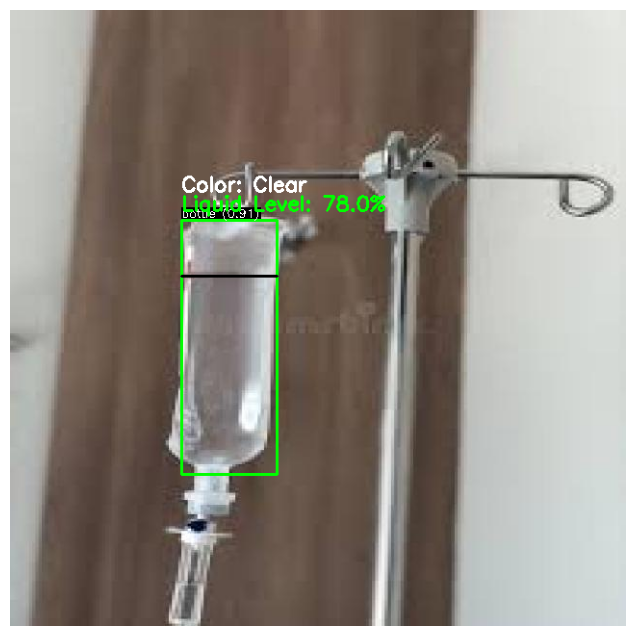

In [155]:
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
import pygame
 
# Initialize the client for Roboflow inference
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="5Oijo8OWOGEpIsnA2iQz"
)
 
# Function to preprocess the image and enhance contours
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return cleaned
 
# Function to detect color in the liquid region
def detect_color(roi):
    # Convert the region of interest to HSV color space
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    # Define color boundaries for common colors
    color_ranges = {
        'Red': ((0, 50, 50), (10, 255, 255)),
        'Yellow': ((15, 50, 50), (35, 255, 255)),
        'Green': ((36, 50, 50), (85, 255, 255)),
        'Blue': ((86, 50, 50), (125, 255, 255)),
        'Clear': ((0, 0, 200), (180, 30, 255))  # Approximation for clear liquids
    }
    max_pixels = 0
    detected_color = 'Unknown'
    # Loop through color ranges to find the dominant color
    for color, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        color_pixels = cv2.countNonZero(mask)
        if color_pixels > max_pixels:
            max_pixels = color_pixels
            detected_color = color
    return detected_color
 
# Function to detect and mark the liquid level
def detect_liquid_level(image, prediction):
    processed = preprocess_image(image)
 
    # Function to play alert sound
    def play_sound():
        pygame.mixer.init()
        pygame.mixer.music.load(r"C:\Users\LAXMI\Downloads\mixkit-appliance-ready-beep-1076.wav")
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            continue
 
    # Get bounding box around the bottle
    x, y, w, h = int(prediction['x'] - prediction['width'] / 2), int(prediction['y'] - prediction['height'] / 2), int(prediction['width']), int(prediction['height'])
    roi_start_y = int(y + h * 0.2)
    roi_end_y = int(y + h * 0.8)
    liquid_level = None
    max_white_pixels = 0
    for i in range(roi_start_y, roi_end_y):
        row = processed[i, x:x + w]
        white_pixels = np.sum(row == 255)
        if white_pixels > max_white_pixels:
            max_white_pixels = white_pixels
            liquid_level = i
    if liquid_level is not None:
        cv2.line(image, (x, liquid_level), (x + w, liquid_level), (0, 0, 0), 2)
        fill_percentage = ((y + h - liquid_level) / h) * 100
        fill_percentage = min(100, max(0, fill_percentage))
        cv2.putText(image, f'Liquid Level: {fill_percentage:.1f}%', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Detect color in the liquid section
        liquid_roi = image[liquid_level:liquid_level + 10, x:x + w]
        detected_color = detect_color(liquid_roi)
        cv2.putText(image, f'Color: {detected_color}', (x, y - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
 
        # Check for threshold alert
        if fill_percentage < 20:
            print(f"Alert: Liquid level is critically low at {fill_percentage:.2f}%.")
            play_sound()
        return fill_percentage, detected_color
 
    return None, None
 
# Function to visualize the results
def visualize_results(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
 
# Main function to process the image
def process_image(image_path):
    original_image = cv2.imread(image_path)
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
    result = CLIENT.infer(encoded_image, model_id="cv-90ctx/3")
 
    predictions = result['predictions']
    for prediction in predictions:
        x = int(prediction['x'] - prediction['width'] / 2)
        y = int(prediction['y'] - prediction['height'] / 2)
        width = int(prediction['width'])
        height = int(prediction['height'])
        confidence = prediction['confidence']
        cv2.rectangle(original_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        label = f"{prediction['class']} ({confidence:.2f})"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.4
        font_thickness = 1
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x
        text_y = y - 3 if y - 3 > 10 else y + 10
        cv2.rectangle(original_image, (text_x, text_y - text_size[1] - 1), 
                      (text_x + text_size[0], text_y + 1), (0, 0, 0), -1)
        cv2.putText(original_image, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
        fill_percentage, detected_color = detect_liquid_level(original_image, prediction)
        if fill_percentage is not None:
            print(f"Detected fill percentage: {fill_percentage:.2f}%, Color: {detected_color}")
 
    visualize_results(original_image)
 
# Provide the path to your image
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"
process_image(image_path)



Detected fill percentage: 78.03%, Color: Clear


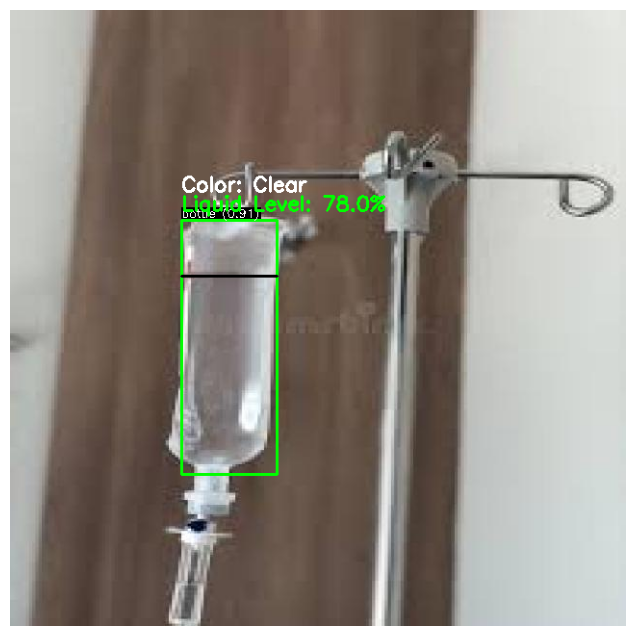

In [157]:
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
import pygame
 
# Initialize the client for Roboflow inference
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="5Oijo8OWOGEpIsnA2iQz"
)
 
# Store initial color
initial_color = None
 
# Initialize pygame mixer for alerts
pygame.mixer.init()
 
# Function to play an alert sound
def play_alert_sound(sound_file):
    pygame.mixer.music.load(sound_file)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        continue
 
# Function to preprocess the image and enhance contours
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return cleaned
 
# Function to detect color in the liquid region
def detect_color(roi):
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    color_ranges = {
        'Red': ((0, 50, 50), (10, 255, 255)),
        'Yellow': ((15, 50, 50), (35, 255, 255)),
        'Green': ((36, 50, 50), (85, 255, 255)),
        'Blue': ((86, 50, 50), (125, 255, 255)),
        'Clear': ((0, 0, 200), (180, 30, 255))
    }
    max_pixels = 0
    detected_color = 'Unknown'
    for color, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        color_pixels = cv2.countNonZero(mask)
        if color_pixels > max_pixels:
            max_pixels = color_pixels
            detected_color = color
    return detected_color
 
# Function to detect and mark the liquid level
def detect_liquid_level(image, prediction):
    global initial_color
    processed = preprocess_image(image)
 
    # Define alert sounds
    color_change_sound = r"C:\Users\LAXMI\Downloads\color_change_alert.wav"
    low_level_sound = r"C:\Users\LAXMI\Downloads\mixkit-appliance-ready-beep-1076.wav"
 
    # Get bounding box around the bottle
    x, y, w, h = int(prediction['x'] - prediction['width'] / 2), int(prediction['y'] - prediction['height'] / 2), int(prediction['width']), int(prediction['height'])
    roi_start_y = int(y + h * 0.2)
    roi_end_y = int(y + h * 0.8)
    liquid_level = None
    max_white_pixels = 0
    for i in range(roi_start_y, roi_end_y):
        row = processed[i, x:x + w]
        white_pixels = np.sum(row == 255)
        if white_pixels > max_white_pixels:
            max_white_pixels = white_pixels
            liquid_level = i
    if liquid_level is not None:
        cv2.line(image, (x, liquid_level), (x + w, liquid_level), (0, 0, 0), 2)
        fill_percentage = ((y + h - liquid_level) / h) * 100
        fill_percentage = min(100, max(0, fill_percentage))
        cv2.putText(image, f'Liquid Level: {fill_percentage:.1f}%', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Detect color in the liquid section
        liquid_roi = image[liquid_level:liquid_level + 10, x:x + w]
        detected_color = detect_color(liquid_roi)
        # Initialize the initial color if it hasn't been set
        if initial_color is None:
            initial_color = detected_color
        # Check for color change and alert if changed
        if detected_color != initial_color:
            cv2.putText(image, f'Color Changed to: {detected_color}', (x, y - 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Alert: Liquid color has changed from {initial_color} to {detected_color}.")
            play_alert_sound(color_change_sound)  # Play sound for color change
 
        # Display detected color on the image
        cv2.putText(image, f'Color: {detected_color}', (x, y - 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
 
        # Check for low-level alert
        if fill_percentage < 20:
            print(f"Alert: Liquid level is critically low at {fill_percentage:.2f}%.")
            play_alert_sound(low_level_sound)  # Play sound for low liquid level
 
        return fill_percentage, detected_color
    return None, None
 
# Function to visualize the results
def visualize_results(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
 
# Main function to process the image
def process_image(image_path):
    original_image = cv2.imread(image_path)
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
    result = CLIENT.infer(encoded_image, model_id="cv-90ctx/3")
    predictions = result['predictions']
    for prediction in predictions:
        x = int(prediction['x'] - prediction['width'] / 2)
        y = int(prediction['y'] - prediction['height'] / 2)
        width = int(prediction['width'])
        height = int(prediction['height'])
        confidence = prediction['confidence']
        cv2.rectangle(original_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        label = f"{prediction['class']} ({confidence:.2f})"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.4
        font_thickness = 1
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = x
        text_y = y - 3 if y - 3 > 10 else y + 10
        cv2.rectangle(original_image, (text_x, text_y - text_size[1] - 1), 
                      (text_x + text_size[0], text_y + 1), (0, 0, 0), -1)
        cv2.putText(original_image, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
        fill_percentage, detected_color = detect_liquid_level(original_image, prediction)
        if fill_percentage is not None:
            print(f"Detected fill percentage: {fill_percentage:.2f}%, Color: {detected_color}")
    visualize_results(original_image)
 
# Provide the path to your image
image_path = r"C:\Users\LAXMI\Downloads\cv images\images-16-_jpeg.rf.260168babb10b1542e83f8f86be55341.jpg"
process_image(image_path)
